  # Autoencoder - SNNL Dev

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
import yaml

import hydra 
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy  
import torch
import torch.nn.functional as F
from torchinfo import summary
import wandb

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
 

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


In [3]:
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace, print_heading, print_underline 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_parameters
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v4, save_checkpoint_v3, save_checkpoint_v4

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-07-08 22:17:05,321 - __main__ - INFO: -  Excution started : 2024_07_08_22:17:05 
2024-07-08 22:17:05,323 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118
2024-07-08 22:17:05,323 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-07-08 22:17:05,324 - __main__ - INFO: -  WandB version    : 0.17.2  		 Pandas version: 2.2.1  


### Hydra

In [5]:
# hydra.core.global_hydra.GlobalHydra.instance().clear()

# abs_config_dir=os.path.abspath("hyperparameters")
# abs_config_dir
# # GlobalHydra.instance().clear() 
# initialize_config_dir(version_base=None, config_dir=abs_config_dir)
# # initialize(version_base=None, config_path="hyperparameters")

# cfg=compose(config_name="AE_Base.yaml")
# type(cfg)
# print(cfg)
# cfgyaml = OmegaConf.to_yaml(cfg)
# type(cfgyaml)
# print(cfgyaml)

### main(args)

In [6]:
WANDB_ACTIVE  = False
LATENT_DIM    = 150
HIDDEN_1      = 512
# HIDDEN_2    = '_256'
HIDDEN_2      = ''
DATE          = 'yymmdd-hhmm'
LOAD_EPOCH    = 200
EPOCHS        = 10
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 0.05
TEMP_LR       = 1.00e-05
CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
CHECKPT

'AE_snnl_dcpb200_150Ltnt_512_yymmdd-hhmm_LAST_ep_200.pt'

In [8]:
# if __name__ == "__main__":
cli_args =   f" --runmode            snnl " \
             f" --configuration      ./hyperparameters/ae_sn_150_512_cpb.yaml" \
             f" --epochs             {EPOCHS} " \
             f" --prim_opt           "\
             f" --lr                 {LEARNING_RATE} "\
             f" --temp_lr            {TEMP_LR}"\
             f" --temp               {TEMP} "\
             f" --temp_annealing     "\
             f" --cpb                {COMPOUNDS_PER_BATCH}" \
	         f" --seed               4321"\
             f" --wandb              "\
             f" --gpu_id             0  "  \
             f" --run_id             z742d8ok " \
             f" --ckpt               AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt " \
             f" "
             # f" --temp_opt " \
             # f" --ckpt               AE_snnl_dcpb200_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt " \
             # f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
             # f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
             # f" --exp_title           snglOpt-050Ltnt_512_sig "
             # f" --runmode            snnl" \
cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt


Namespace(configuration='./hyperparameters/ae_sn_150_512_cpb.yaml', ckpt='AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt', cpb=200, exp_title=None, epochs=10, gpu_id=0, learning_rate=0.0001, exp_id='z742d8ok', runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=True, use_single_loss=False, temperature=0.05, temperatureLR=1e-05, wandb=True)

2024-07-08 22:18:29,178 - snnl.utils.utils - INFO: -  command line param configuration             : [./hyperparameters/ae_sn_150_512_cpb.yaml]
2024-07-08 22:18:29,179 - snnl.utils.utils - INFO: -  command line param ckpt                      : [AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt]
2024-07-08 22:18:29,180 - snnl.utils.utils - INFO: -  command line param cpb                       : [200]
2024-07-08 22:18:29,181 - snnl.utils.utils - INFO: -  command line param exp_title                 : [None]
2024-07-08 22:18:29,181 - snnl.utils.utils - INFO: -  command line param epochs                    : [10]
2024-07-08 22:18:29,182 - snnl.utils.utils - INFO: -  command line param gpu_id                    : [0]
2024-07-08 22:18:29,183 - snnl.utils.utils - INFO: -  command line param learning_rate             : [0.0001]
2024-07-08 22:18:29,183 - snnl.utils.utils - INFO: -  command line param exp_id                    : [z742d8ok]
2024-07-08 22:18:29,184 - snnl.utils.utils - INF

'AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt'

In [8]:
args

namespace(project_name='CellPainting_Profiles',
          exp_id=None,
          exp_name_pfx=None,
          exp_name=None,
          exp_date=None,
          exp_title='dcpb200_150Ltnt_512',
          exp_description='AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb',
          exp_folder=None,
          folder_sfx=None,
          random_seed=4321,
          units=[['linear', 1471, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 150],
                 ['linear', 150, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 1471]],
          input_shape=1471,
          code_units=150,
          embedding_layer=4,
          show_every=1,
          save_every=25,
          learning_rate=0.0001,
          loss_factor=1.0,
          adam_weight_decay=0,
          snnl_factor=0.5,
          tempera

In [9]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device()
    # print(f"Current device is : {current_device}")    
    current_device = set_device(args.gpu_id)
    current_device = get_device()


2024-07-08 22:18:38,943 - __main__ - INFO: -  Checkpoint AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt found
2024-07-08 22:18:38,944 - __main__ - INFO: -  Resuming training using checkpoint: AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt
2024-07-08 22:18:39,682 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-07-08 22:18:39,684 - snnl.utils.utils - INFO: -  Switched to: Quadro GV100 - 0
2024-07-08 22:18:39,685 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100


#### Define dataset and dataloaders

In [10]:
#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

2024-07-08 22:18:44,523 - root - INFO: -  load cellpainting
2024-07-08 22:18:44,524 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-07-08 22:18:44,525 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-07-08 22:18:44,526 - snnl.utils.dataloader - INFO: -  type    :  train
2024-07-08 22:18:44,526 - snnl.utils.dataloader - INFO: -  start   :  0
2024-07-08 22:18:44,527 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-07-08 22:18:44,527 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-07-08 22:18:44,528 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 200.0 compounds with 3 samples per compound : total 600 rows
2024-07-08 22:18:44,529 - snnl.utils.dataloader - INFO: -  Number of 600 row full size batches per epoch: 400
2024-07-08 22:18:44,529 - snnl.utils.dataloader - INFO: -  Rows covered by 400 full size batches (

#### WandB Setup

In [12]:
# args.exp_id   = None
# args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
# args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = None 
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
logger.info(f" args.wandb       : {args.wandb}")
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")

2024-07-08 22:19:09,609 - __main__ - INFO: -  args.wandb       : True
2024-07-08 22:19:09,610 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-07-08 22:19:09,611 - __main__ - INFO: -  Experiment Id    : z742d8ok
2024-07-08 22:19:09,613 - __main__ - INFO: -  Experiment Name  : AE_240708_2218
2024-07-08 22:19:09,614 - __main__ - INFO: -  Experiment Date  : 240708_2218
2024-07-08 22:19:09,615 - __main__ - INFO: -  Experiment Title : dcpb200_150Ltnt_512
2024-07-08 22:19:09,616 - __main__ - INFO: -  Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb


In [13]:
WANDB_ACTIVE = args.wandb

EXP_DATE = datetime.now().strftime('%y%m%d_%H%M')
args.exp_name = f"AE_{EXP_DATE}"
args.exp_date = EXP_DATE
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")

if WANDB_ACTIVE:
    if args.exp_id is not None:
        print(" *******  Resume W&B Tracking ******* ")
        resume_wandb = True
    else:
        print(" *****  Initialize W&B Tracking ***** ")
        resume_wandb = False
        args.exp_name = f"AE_{EXP_DATE}"
        
    wandb_run = init_wandb(args)
    args.exp_id = wandb_run.id
    wandb_status = " ***** W&B Tracking Started ***** "
else: 
    wandb_status = " ***** W&B Logging INACTIVE ***** "
    args.exp_name = 'AE_'+datetime.now().strftime('%y%m%d_%H%M')
    args.exp_date = datetime.now().strftime('%y%m%d_%H%M')    


logger.info(f" {wandb_status}")
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")

2024-07-08 22:19:11,780 - __main__ - INFO: -  Experiment Name  : AE_240708_2219
2024-07-08 22:19:11,782 - __main__ - INFO: -  Experiment Date  : 240708_2219


Resume


wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


2024-07-08 22:19:14,690 - __main__ - INFO: -   ***** W&&B Tracking Started ***** 
2024-07-08 22:19:14,692 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-07-08 22:19:14,693 - __main__ - INFO: -  Experiment Id    : z742d8ok
2024-07-08 22:19:14,694 - __main__ - INFO: -  Experiment Name  : AE_20240708_0539
2024-07-08 22:19:14,695 - __main__ - INFO: -  Experiment Date  : 240708_2219
2024-07-08 22:19:14,696 - __main__ - INFO: -  Experiment Title : dcpb200_150Ltnt_512
2024-07-08 22:19:14,697 - __main__ - INFO: -  Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb


# Define autoencoder model

### Override arguments

In [13]:
# args.temperature   = 0.8
# args.loss_factor   = 2.0        ## 2.0e+00
# args.snnl_factor   = 0.5       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 1.0e-04    ## 1e-4
# print(f"   Latent dim        {args.code_units}  \t\t  loss_factor       {args.loss_factor}  \t\t   snnl_factor       {args.snnl_factor}")
# print(f"   temperature       {args.temperature} \t\t  learning_rate     {args.learning_rate} \t\t   temperatureLR:    {args.temperatureLR}")

In [14]:
# list_namespace(args)

## Define Model

In [14]:
model = define_autoencoder_model(args,device = current_device)

if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)

2024-07-08 22:19:19,396 - snnl.utils.utils - INFO: - Defining model in SNNL mode 
2024-07-08 22:19:19,398 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-07-08 22:19:19,434 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-08 22:19:19,435 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-07-08 22:19:19,442 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-08 22:19:19,443 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-07-08 22:19:19,445 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    150  outp

 EMBEDDING LAYER: 4


### Load model checkpoint 

In [15]:
if args.ckpt is not None:
    model.resume_training = True
    model , last_epoch = load_checkpoint_v4(model, args.ckpt, verbose = True )  
    model.train()
    model.device = current_device
    model = model.cuda(device=current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
    model.starting_epoch = last_epoch
    model.ending_epoch = last_epoch + args.epochs
    logging.info(f" RESUME TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

    if 'gen' not in model.training_history:
        print(f" Define self.training_history['gen'] ")
        model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': np.inf, 'trn_best_loss_ep' : 0 ,
                                        'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': np.inf, 'val_best_loss_ep' : 0 }        
    
        for key in ['trn', 'val']:
            tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
            model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
            model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
            
            tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
            model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
            model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
    
else:
    model.resume_training = False
    model.starting_epoch = 0
    model.ending_epoch = args.epochs
    logging.info(f" INITIALIZE TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

model.best_metric = model.training_history['gen'][f'val_best_metric']  
model.best_epoch  = model.training_history['gen'][f'val_best_metric_ep']  

2024-07-08 22:19:22,353 - root - INFO: -  Load model checkpoint from  AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt


Other Exception
(<class 'RuntimeError'>, RuntimeError('PytorchStreamReader failed locating file data.pkl: file not found'), <traceback object at 0x7f1b5482a240>)


UnboundLocalError: cannot access local variable 'checkpoint' where it is not associated with a value

In [17]:
display_model_parameters(model)

if WANDB_ACTIVE:
    wandb.config.update(args)

 Model device           : cuda:0
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : False
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True
 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fea5e725850> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 Use snnl               : True
 SNNL factor            : 0.5
 SNNL temperature       : Parameter containing:
tensor([1.], device='cuda:0', requires_grad

# Autoencoder Fit 

In [18]:
model.starting_epoch, model.ending_epoch = 0, 10
model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(0, 10)

 2024-07-07 17:28:29  epoch    1 of   10


In [ ]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
header = True

for epoch in range(model.starting_epoch, model.ending_epoch):
    train_loss = model.epoch_train(train_loader, epoch, DEBUG_COUNT = 3)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, model.ending_epoch, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y     for x,y in model.training_history['gen'].items()} | \
                        {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if model.new_val_best:
        if WANDB_ACTIVE:
            wandb.unwatch(model)
            save_checkpoint_v4(epoch+1, model, args, update_best=True)  
            wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
        else:
            save_checkpoint_v4(epoch+1, model, args, update_best=True)  
        
    if (epoch + 1) % args.save_every == 0:
        if WANDB_ACTIVE:
            wandb.unwatch(model)
            save_checkpoint_v4(epoch+1, model, args)    
            wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
        else:
            save_checkpoint_v4(epoch+1, model, args)    
            
print(f"Last Epoch {epoch+1}")
if WANDB_ACTIVE:
    wandb.unwatch(model)
    save_checkpoint_v4(epoch+1, model, args, update_latest=True)          
else:
    save_checkpoint_v4(epoch+1, model, args)    


 2024-07-08 19:09:56  epoch  101 of  200
 100 - anneal temp  -  counter: 4    before:   0.466516     new_temp:   0.412635 
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
19:12:29 101/200  |   2.9638     0.1208     2.8430 |   0.412635   0.0000e+00 |   0.6758    50           |   2.9676     0.1252     2.8424 |   0.6080   101             |  1.000e-04   0.000e+00 |


2024-07-08 19:12:30,124 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 101


19:14:58 102/200  |   2.9627     0.1205     2.8421 |   0.412635   0.0000e+00 |   0.6765    50           |   2.9673     0.1249     2.8424 |   0.5477   101             |  1.000e-04   0.000e+00 |
19:17:30 103/200  |   2.9624     0.1203     2.8421 |   0.412635   0.0000e+00 |   0.6784    50           |   2.9672     0.1249     2.8423 |   0.5916   101             |  1.000e-04   0.000e+00 |
19:20:02 104/200  |   2.9622     0.1201     2.8421 |   0.412635   0.0000e+00 |   0.6782    50           |   2.9672     0.1249     2.8423 |   0.5581   101             |  1.000e-04   0.000e+00 |
19:22:32 105/200  |   2.9620     0.1199     2.8421 |   0.412635   0.0000e+00 |   0.6770    50           |   2.9670     0.1246     2.8423 |   0.6044   101             |  1.000e-04   0.000e+00 |
19:25:02 106/200  |   2.9618     0.1197     2.8421 |   0.412635   0.0000e+00 |   0.6785    50           |   2.9665     0.1242     2.8423 |   0.5797   101             |  1.000e-04   0.000e+00 |
19:27:33 107/200  |   2.9616     0.

2024-07-08 19:27:34,375 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 107


19:30:04 108/200  |   2.9613     0.1193     2.8420 |   0.412635   0.0000e+00 |   0.6805    50           |   2.9662     0.1239     2.8422 |   0.5818   107             |  1.000e-04   0.000e+00 |
19:32:32 109/200  |   2.9611     0.1190     2.8420 |   0.412635   0.0000e+00 |   0.6784    50           |   2.9662     0.1240     2.8422 |   0.5994   107             |  1.000e-04   0.000e+00 |
19:35:01 110/200  |   2.9609     0.1189     2.8420 |   0.412635   0.0000e+00 |   0.6785    50           |   2.9657     0.1236     2.8422 |   0.5902   107             |  1.000e-04   0.000e+00 |
19:37:30 111/200  |   2.9607     0.1187     2.8419 |   0.412635   0.0000e+00 |   0.6821    50           |   2.9657     0.1235     2.8422 |   0.5912   107             |  1.000e-04   0.000e+00 |
 111 - anneal temp  -  counter: 5    before:   0.412635     new_temp:   0.373265 
19:40:01 112/200  |   2.9605     0.1185     2.8419 |   0.373265   0.0000e+00 |   0.6819    50           |   2.9644     0.1230     2.8414 |   0.588

2024-07-08 19:45:00,587 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 114


19:47:32 115/200  |   2.9590     0.1179     2.8411 |   0.373265   0.0000e+00 |   0.6762    50           |   2.9640     0.1227     2.8413 |   0.5833   114             |  1.000e-04   0.000e+00 |
19:50:04 116/200  |   2.9587     0.1177     2.8411 |   0.373265   0.0000e+00 |   0.6836    50           |   2.9638     0.1225     2.8413 |   0.6116   114             |  1.000e-04   0.000e+00 |
19:52:34 117/200  |   2.9585     0.1174     2.8411 |   0.373265   0.0000e+00 |   0.6787    50           |   2.9635     0.1222     2.8413 |   0.5943   114             |  1.000e-04   0.000e+00 |
19:55:05 118/200  |   2.9582     0.1172     2.8411 |   0.373265   0.0000e+00 |   0.6815    50           |   2.9638     0.1225     2.8413 |   0.6019   114             |  1.000e-04   0.000e+00 |
19:57:36 119/200  |   2.9580     0.1170     2.8410 |   0.373265   0.0000e+00 |   0.6832    50           |   2.9636     0.1224     2.8413 |   0.5878   114             |  1.000e-04   0.000e+00 |
20:00:06 120/200  |   2.9579     0.

2024-07-08 20:10:10,031 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 124
2024-07-08 20:12:41,075 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_ep_125.pt - epoch: 125


20:12:40 125/200  |   2.9558     0.1157     2.8402 |   0.342923   0.0000e+00 |   0.6850    50           |   2.9613     0.1208     2.8404 |   0.5909   124             |  1.000e-04   0.000e+00 |
20:15:12 126/200  |   2.9557     0.1156     2.8401 |   0.342923   0.0000e+00 |   0.6838    50           |   2.9608     0.1205     2.8404 |   0.5915   124             |  1.000e-04   0.000e+00 |
20:17:43 127/200  |   2.9555     0.1154     2.8401 |   0.342923   0.0000e+00 |   0.6874    50           |   2.9608     0.1205     2.8404 |   0.6389   127             |  1.000e-04   0.000e+00 |


2024-07-08 20:17:43,965 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 127


20:20:13 128/200  |   2.9553     0.1152     2.8401 |   0.342923   0.0000e+00 |   0.6907    50           |   2.9608     0.1205     2.8403 |   0.5891   127             |  1.000e-04   0.000e+00 |
20:22:44 129/200  |   2.9551     0.1150     2.8400 |   0.342923   0.0000e+00 |   0.6864    50           |   2.9605     0.1202     2.8403 |   0.6300   127             |  1.000e-04   0.000e+00 |
20:25:14 130/200  |   2.9549     0.1149     2.8400 |   0.342923   0.0000e+00 |   0.6923   130           |   2.9603     0.1200     2.8403 |   0.6319   127             |  1.000e-04   0.000e+00 |
20:27:45 131/200  |   2.9546     0.1147     2.8400 |   0.342923   0.0000e+00 |   0.6904   130           |   2.9602     0.1200     2.8402 |   0.5971   127             |  1.000e-04   0.000e+00 |
20:30:13 132/200  |   2.9544     0.1145     2.8400 |   0.342923   0.0000e+00 |   0.6949   132           |   2.9600     0.1198     2.8402 |   0.6155   127             |  1.000e-04   0.000e+00 |
20:32:42 133/200  |   2.9543     0.

2024-07-08 20:57:43,567 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 143


21:00:12 144/200  |   2.9518     0.1130     2.8388 |   0.318640   0.0000e+00 |   0.7000   144           |   2.9579     0.1189     2.8390 |   0.6165   143             |  1.000e-04   0.000e+00 |
21:02:43 145/200  |   2.9517     0.1130     2.8387 |   0.318640   0.0000e+00 |   0.6983   144           |   2.9573     0.1182     2.8390 |   0.6534   145             |  1.000e-04   0.000e+00 |


2024-07-08 21:02:43,392 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 145


21:05:13 146/200  |   2.9515     0.1128     2.8387 |   0.318640   0.0000e+00 |   0.7006   146           |   2.9573     0.1184     2.8389 |   0.6319   145             |  1.000e-04   0.000e+00 |
21:07:41 147/200  |   2.9515     0.1129     2.8386 |   0.318640   0.0000e+00 |   0.6997   146           |   2.9571     0.1182     2.8389 |   0.6600   147             |  1.000e-04   0.000e+00 |


2024-07-08 21:07:42,304 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 147


21:10:11 148/200  |   2.9513     0.1127     2.8386 |   0.318640   0.0000e+00 |   0.7003   146           |   2.9568     0.1180     2.8388 |   0.6099   147             |  1.000e-04   0.000e+00 |
21:12:42 149/200  |   2.9510     0.1124     2.8385 |   0.318640   0.0000e+00 |   0.6976   146           |   2.9568     0.1179     2.8389 |   0.6524   147             |  1.000e-04   0.000e+00 |


2024-07-08 21:15:11,784 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_ep_150.pt - epoch: 150


21:15:11 150/200  |   2.9507     0.1122     2.8385 |   0.318640   0.0000e+00 |   0.6996   146           |   2.9565     0.1178     2.8388 |   0.6329   147             |  1.000e-04   0.000e+00 |
21:17:41 151/200  |   2.9505     0.1120     2.8385 |   0.318640   0.0000e+00 |   0.6974   146           |   2.9565     0.1178     2.8387 |   0.6384   147             |  1.000e-04   0.000e+00 |
21:20:12 152/200  |   2.9504     0.1120     2.8384 |   0.318640   0.0000e+00 |   0.6953   146           |   2.9564     0.1178     2.8386 |   0.6608   152             |  1.000e-04   0.000e+00 |


2024-07-08 21:20:13,043 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 152


 152 - anneal temp  -  counter: 8    before:   0.318640     new_temp:   0.298653 
21:22:45 153/200  |   2.9502     0.1119     2.8383 |   0.298653   0.0000e+00 |   0.6966   146           |   2.9552     0.1174     2.8379 |   0.6353   152             |  1.000e-04   0.000e+00 |
21:25:13 154/200  |   2.9492     0.1116     2.8375 |   0.298653   0.0000e+00 |   0.6960   146           |   2.9553     0.1175     2.8378 |   0.6436   152             |  1.000e-04   0.000e+00 |
21:27:42 155/200  |   2.9490     0.1115     2.8375 |   0.298653   0.0000e+00 |   0.6964   146           |   2.9549     0.1171     2.8378 |   0.6364   152             |  1.000e-04   0.000e+00 |
21:30:11 156/200  |   2.9487     0.1112     2.8375 |   0.298653   0.0000e+00 |   0.7001   146           |   2.9548     0.1170     2.8377 |   0.6618   156             |  1.000e-04   0.000e+00 |


2024-07-08 21:30:11,549 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 156


21:32:42 157/200  |   2.9486     0.1111     2.8374 |   0.298653   0.0000e+00 |   0.6991   146           |   2.9545     0.1168     2.8377 |   0.6398   156             |  1.000e-04   0.000e+00 |
21:35:11 158/200  |   2.9484     0.1111     2.8373 |   0.298653   0.0000e+00 |   0.7009   158           |   2.9542     0.1166     2.8376 |   0.6611   156             |  1.000e-04   0.000e+00 |
21:37:41 159/200  |   2.9482     0.1109     2.8373 |   0.298653   0.0000e+00 |   0.7031   159           |   2.9546     0.1170     2.8376 |   0.6565   156             |  1.000e-04   0.000e+00 |
21:40:02 160/200  |   2.9481     0.1110     2.8371 |   0.298653   0.0000e+00 |   0.7044   160           |   2.9539     0.1166     2.8374 |   0.6720   160             |  1.000e-04   0.000e+00 |


2024-07-08 21:40:03,338 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 160


21:42:22 161/200  |   2.9478     0.1108     2.8371 |   0.298653   0.0000e+00 |   0.7049   161           |   2.9538     0.1164     2.8374 |   0.6563   160             |  1.000e-04   0.000e+00 |
21:44:41 162/200  |   2.9475     0.1104     2.8370 |   0.298653   0.0000e+00 |   0.7077   162           |   2.9537     0.1164     2.8373 |   0.6373   160             |  1.000e-04   0.000e+00 |
21:47:04 163/200  |   2.9472     0.1102     2.8370 |   0.298653   0.0000e+00 |   0.7076   162           |   2.9539     0.1165     2.8374 |   0.6631   160             |  1.000e-04   0.000e+00 |
21:49:26 164/200  |   2.9471     0.1100     2.8370 |   0.298653   0.0000e+00 |   0.7079   164           |   2.9531     0.1158     2.8373 |   0.6571   160             |  1.000e-04   0.000e+00 |
21:51:46 165/200  |   2.9470     0.1100     2.8370 |   0.298653   0.0000e+00 |   0.7057   164           |   2.9531     0.1158     2.8373 |   0.6596   160             |  1.000e-04   0.000e+00 |
21:54:07 166/200  |   2.9468     0.

2024-07-08 21:56:30,165 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 167


21:58:52 168/200  |   2.9464     0.1096     2.8368 |   0.298653   0.0000e+00 |   0.7066   164           |   2.9524     0.1153     2.8371 |   0.6557   167             |  1.000e-04   0.000e+00 |
22:01:13 169/200  |   2.9462     0.1096     2.8367 |   0.298653   0.0000e+00 |   0.7068   164           |   2.9522     0.1153     2.8369 |   0.6340   167             |  1.000e-04   0.000e+00 |
 169 - anneal temp  -  counter: 9    before:   0.298653     new_temp:   0.281838 
22:03:37 170/200  |   2.9459     0.1092     2.8367 |   0.281838   0.0000e+00 |   0.7063   164           |   2.9515     0.1152     2.8363 |   0.6891   170             |  1.000e-04   0.000e+00 |


2024-07-08 22:03:37,384 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240707_1728_BEST.pt - epoch: 170


22:06:01 171/200  |   2.9450     0.1091     2.8359 |   0.281838   0.0000e+00 |   0.7115   171           |   2.9511     0.1149     2.8362 |   0.6469   170             |  1.000e-04   0.000e+00 |
22:08:28 172/200  |   2.9448     0.1089     2.8359 |   0.281838   0.0000e+00 |   0.7076   171           |   2.9509     0.1147     2.8362 |   0.6542   170             |  1.000e-04   0.000e+00 |
22:10:52 173/200  |   2.9446     0.1087     2.8359 |   0.281838   0.0000e+00 |   0.7065   171           |   2.9509     0.1149     2.8360 |   0.6509   170             |  1.000e-04   0.000e+00 |
22:13:13 174/200  |   2.9443     0.1084     2.8359 |   0.281838   0.0000e+00 |   0.7109   171           |   2.9507     0.1145     2.8362 |   0.6737   170             |  1.000e-04   0.000e+00 |


### Close WandB Logging

In [24]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

temp_grad_hist,0
temp_hist,0.17027
temp_lr,0
trn_R2_score,0.77354
trn_R2_score_tev,0
trn_best_loss,2.89471
trn_best_loss_ep,399
trn_best_metric,0.77354
trn_best_metric_ep,399
trn_lr,0.0001
trn_prim_loss,0.08697


In [ ]:
epoch, model.starting_epoch, model.ending_epoch

In [25]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
17:30:36  1 /100  |   3.6449     0.8119     2.8330 |   1.000000   0.0000e+00 | -11.8533    50           |   3.3535     0.5182     2.8353 |  -4.5372    93             |  1.000e-04   0.000e+00 |
17:32:43  2 /100  |   3.2799     0.4421     2.8378 |   1.000000   0.0000e+00 |  -3.1303    50           |   3.2152     0.3743     2.8409 |  -1.8841    93             |  1.000e-04   0.000e+00 |
17:34:50  3 /100  |   3.1859     0.3438     2.8421 |   1.000000   0.0000e+00 |  -1.3209    50           |   3.1548     0.3114     2.8434 |  -0.7997    93             |  1.000e-04   0.000e+00 |
17:36:58  4 /100  |   3.1386     0.

In [28]:
# model.starting_epoch = 59
# epochs = 100
# model.ending_epoch = 100
model.starting_epoch = model.ending_epoch
model.ending_epoch += 100

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240708_190948  epoch  101 of  200


## Misc stuff

In [ ]:
# save_checkpoint_v3(1, model, args, update_latest=True)  

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature
display_epoch_metrics(model, epoch, model.ending_epoch, header = True)

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
model.state_dict().keys()
# for k in ['temperature', 'snnl_criterion.temperature'
for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
    if model.state_dict()[k].ndim > 1:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
    else:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

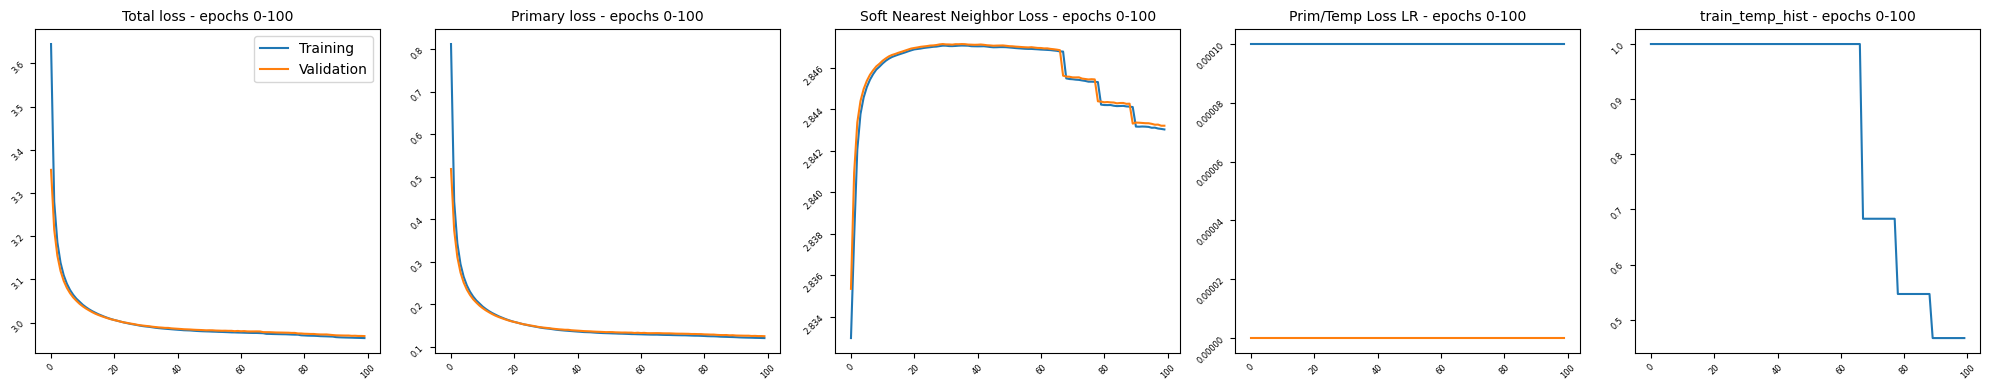

In [26]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

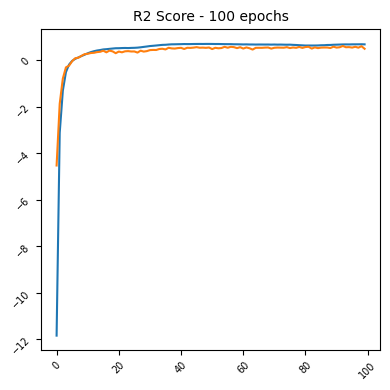

In [27]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
args.compounds_per_batch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [ ]:
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240509'
ex_title = args.exp_title
compounds_per_batch = args.compounds_per_batch


In [ ]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [ ]:
filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"   
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

In [ ]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs, 

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__

# Misc code

In [ ]:
if # model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [ ]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# model.training_history['val'].keys()
# np.argmin(model.training_history['trn']['trn_ttl_loss']), np.min(model.training_history['trn']['trn_ttl_loss'] )
# np.argmin(model.training_history['trn']['trn_prim_loss']),np.min(model.training_history['trn']['trn_prim_loss']), np.min(model.training_history['trn']['trn_prim_loss'])  / model.loss_factor
# np.argmin(model.training_history['trn']['trn_snn_loss']), np.min(model.training_history['trn']['trn_snn_loss'] ),  np.min(model.training_history['trn']['trn_snn_loss'] ) / model.snnl_factor
# print()
# np.argmin(model.training_history['val']['val_ttl_loss']) , np.min(model.training_history['val']['val_ttl_loss'] )
# np.argmin(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']) / model.loss_factor
# np.argmin(model.training_history['val']['val_snn_loss']) , np.min(model.training_history['val']['val_snn_loss'] ), np.min(model.training_history['val']['val_snn_loss'] ) / model.snnl_factor

# model.optimizer
# model.optimizer.state_dict()
# model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr']
# model.scheduler.__dict__

# model.temp_optimizer
# model.temp_scheduler.__dict__
# model.temp_scheduler = model._ReduceLROnPlateau(model.temp_optimizer, mode='min', factor=0.75, patience=35, 
                                              # threshold=1.0e-7, threshold_mode='rel', 
                                              # cooldown=15, min_lr=0, eps=1e-08, verbose =True)  
# model.temp_scheduler['patience'] = 35

In [ ]:
# temp_params = [p for name, p in model.named_parameters() if 'temperature' in name]
# network_params = [p for name, p in model.named_parameters() if 'temperature' not in name]
# for t in temp_params:
#     t.requires_grad = False 

In [ ]:
# model.optimizer = torch.optim.Adam(params = network_params, lr=0.001, weight_decay = 0.1)
# # if self.use_snnl:
# #     self.optimizer.add_param_group({'params': temp_params, 'lr': temperatureLR, 'weight_decay': adam_weight_decay})

# if model.use_scheduler:
#     model.scheduler = model._ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=40, threshold=0.000001, 
#                                              threshold_mode='rel', cooldown=10, min_lr=0, eps=1e-08, verbose =True) 

In [16]:

# if self.use_annealing andd self.best_metric - self.training_history[key][f"{key}_R2_score"][-1] < 1.0e-05:
#     self.R2_improvment_counter += 1
#     if self.R2_improvement_counter > 10:
#         with torch.no_grad():
#             self.temperature.copy_(1.0 / ((1.0 + self.temp_decay_counter) ** 0.55))
#         self.temp_decay_counter += 1
#         self.R2_improvement_counter = 0
#         # print(f" {epoch} - anneal temp  -  before: {temp_before:10.6f}     new_temp: {self.temperature.item():10.6f} ")
 

In [22]:
def load_checkpoint_v4(model, filename, dryrun = False,verbose=False):
    epoch = -1
    if filename[-3:] != '.pt':
        filename+='.pt'
    logging.info(f" Load model checkpoint from  {filename}")    
    ckpt_file = os.path.join("ckpts", filename)
    print(ckpt_file)
    try:
        checkpoint = torch.load(ckpt_file)
    except FileNotFoundError:
        Exception("Previous state checkpoint not found.")
        print("FileNotFound Exception")
    except :
        print("Other Exception")
        print(sys.exc_info())
        
    print(checkpoint.keys())
    for key, value in checkpoint.items():
        logging.debug(f"{key:40s}, {str(type(value)):60s}  -- model attr set")
    
    if not dryrun:
        model.load_state_dict(checkpoint['state_dict'])
        if verbose:
            print(f"model state dict:\n {checkpoint['state_dict'].keys()}")
            print(f"   temperature  :   {checkpoint['state_dict']['temperature'].item()}")
            print(f"   snnl_criterion.temperature: {checkpoint['state_dict']['snnl_criterion.temperature'].item()}")

        for key, value in checkpoint['params'].items():
            logging.debug(f"{key:40s}, {str(type(value)):60s}  -- model attr set")
            model.__dict__[key] = value
            
        model.optimizers = {k:v for k,v in checkpoint['optimizers'].items()}
        model.schedulers = {k:v for k,v in checkpoint['schedulers'].items()}
        
        for k,v in checkpoint['optimizers_state_dict'].items():
            model.optimizers[k].load_state_dict(v)
        for k,v in checkpoint['schedulers_state_dict'].items():
            model.schedulers[k].load_state_dict(v)

        # if model.optimizer is not None:
        #     model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #     if verbose:
        #         print(f"optimizer state dict:\n {checkpoint['optimizer_state_dict']['param_groups']}")

        # if model.scheduler is not None:
        #     model.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        #     if verbose:
        #         print(f"scheduler state dict:\n  {checkpoint['scheduler_state_dict']}")           
        
        # if model.temp_optimizer is not None:
        #     model.temp_optimizer.load_state_dict(checkpoint['temp_optimizer_state_dict'])
        #     if verbose:
        #         print(f"temp optimizer state dict:\n  {checkpoint['temp_optimizer_state_dict']['param_groups']}")
            
        # if model.temp_scheduler is not None:
        #     model.temp_scheduler.load_state_dict(checkpoint['temp_scheduler_state_dict'])
        #     if verbose:
        #         print(f"temp scheduler state dict:\n  {checkpoint['temp_scheduler_state_dict']}")
    else:
        for key, value in checkpoint['params'].items():
            logging.debug(f"{key:40s}, {str(type(value)):60s}  -- model attr set")

    epoch = checkpoint.get('epoch',-1)
    logger.info(f" ==> Loaded from checkpoint {filename} successfully. last epoch on checkpoint: {epoch}")
    logger.info(f"     Model best metric      : {model.best_metric:6f} - epoch: {model.best_epoch}") 

    if 'gen' not in model.training_history:
        print(f" Define self.training_history['gen'] ")
        model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': np.inf, 'trn_best_loss_ep' : 0 ,
                                        'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': np.inf, 'val_best_loss_ep' : 0 }        
    
        for key in ['trn', 'val']:
            tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
            model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
            model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
            
            tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
            model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
            model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
            
        model.best_metric = model.training_history['gen'][f'val_best_metric']  
        model.best_epoch  = model.training_history['gen'][f'val_best_metric_ep']              
        
    return model, epoch


In [23]:
model , last_epoch = load_checkpoint_v4(model, args.ckpt, verbose = True )  

2024-07-08 22:25:59,154 - root - INFO: -  Load model checkpoint from  AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt


ckpts/AE_snnl_dcpb200_150Ltnt_512_20240708_0539_LAST_ep_400.pt
Other Exception
(<class 'RuntimeError'>, RuntimeError('PytorchStreamReader failed locating file data.pkl: file not found'), <traceback object at 0x7f1b34689880>)


UnboundLocalError: cannot access local variable 'checkpoint' where it is not associated with a value